<a href="https://colab.research.google.com/github/salihdegrli/churn_analysis/blob/main/churn_analysis_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install catboost

In [2]:
!pip install scikit-learn==1.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.0/32.0 MB 18.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.34.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.1.3 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.1.3 which is incompatible.


In [3]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.1.3
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.11/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, fastai, imbalanced-learn, librosa, mlxtend, sentence-transformers, shap, sklearn-compat, sklearn-pandas, yellowbrick


In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import eda
import data_prep
import pylab as pl
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, validation_curve, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import joblib
import pickle
import warnings
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

##Load Data

In [5]:
df = pd.read_csv("churn_train.csv")

In [6]:
#datasetin tamamı 2013 yılına ait olduğu için yıl değişkeni kaldırıldı.
df.drop("year", axis=1, inplace=True)
#user_account_id her kişi için unique olduğu için datasetten kaldırıldı.
df.drop("user_account_id", axis=1, inplace=True)
# user_lifetime'ı 0 olanlar üzerinden bir analiz yapılamayacağı için datasetten kaldırıldı.
df.drop((df.user_lifetime[df.user_lifetime == 0].index), axis=0, inplace=True)

##Data Prep

In [7]:
#@title Feature Engineering
df["average_monthly_spending"] = df["user_spendings"] / df["user_lifetime"]
df["average_usage_rate"] = (df["calls_outgoing_count"] + df["sms_outgoing_count"] + df["gprs_session_count"] + df["reloads_count"]) / df["user_lifetime"]
df["average_calls_outgoing_count"] = df["calls_outgoing_count"] / df["user_lifetime"]
df["average_sms_outgoing_count"] = df["sms_outgoing_count"] / df["user_lifetime"]
df["average_gprs_session_count"] = df["gprs_session_count"] / df["user_lifetime"]


In [11]:
cat_cols, num_cols, cat_but_car = eda.grab_col_names(df)

Observations: 59971
Variables: 69
cat_cols: 7
num_cols: 62
cat_but_car: 0
num_but_cat: 7


In [8]:
data_prep.check_missing_value(df)

False

In [12]:
data_prep.remove_outlier_with_lof(df, num_cols, inplace=True, plot=False)

In [13]:
for cat_col in cat_cols:
  print(df[cat_col].value_counts())

month
6    52018
8     7450
7      500
Name: count, dtype: int64
user_intake
0    57532
1     2436
Name: count, dtype: int64
user_has_outgoing_calls
1    48256
0    11712
Name: count, dtype: int64
user_has_outgoing_sms
1    36148
0    23820
Name: count, dtype: int64
user_use_gprs
0    57265
1     2703
Name: count, dtype: int64
user_does_reload
1    33602
0    26366
Name: count, dtype: int64
churn
0    47429
1    12539
Name: count, dtype: int64


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
month,59968.000,6.257,0.663,6.000,6.000,6.000,6.000,8.000
user_lifetime,59968.000,4012.052,6062.619,1.000,457.000,1219.000,1985.000,15947.000
user_intake,59968.000,0.041,0.197,0.000,0.000,0.000,0.000,1.000
user_no_outgoing_activity_in_days,59968.000,63.996,264.082,0.000,1.000,2.000,8.000,1276.000
user_account_balance_last,59968.000,9.625,18.510,0.000,0.040,5.250,12.900,1775.710
...,...,...,...,...,...,...,...,...
average_monthly_spending,59968.000,0.040,0.387,-1.582,0.000,0.002,0.011,51.000
average_usage_rate,59968.000,0.462,5.236,0.000,0.002,0.030,0.127,605.000
average_calls_outgoing_count,59968.000,0.189,1.569,0.000,0.001,0.015,0.062,265.000
average_sms_outgoing_count,59968.000,0.188,2.742,0.000,0.000,0.004,0.040,521.000


In [14]:
df = data_prep.one_hot_encoder(df, ["month"])

In [15]:
df = df.sample(frac=1).reset_index(drop=True)

In [16]:
y = df.churn
X = df.drop(["churn"], axis=1)
X.head()

,user_lifetime,user_intake,user_no_outgoing_activity_in_days,user_account_balance_last,user_spendings,user_has_outgoing_calls,user_has_outgoing_sms,user_use_gprs,user_does_reload,reloads_inactive_days,reloads_count,reloads_sum,calls_outgoing_count,calls_outgoing_spendings,calls_outgoing_duration,calls_outgoing_spendings_max,calls_outgoing_duration_max,calls_outgoing_inactive_days,calls_outgoing_to_onnet_count,calls_outgoing_to_onnet_spendings,calls_outgoing_to_onnet_duration,calls_outgoing_to_onnet_inactive_days,calls_outgoing_to_offnet_count,calls_outgoing_to_offnet_spendings,calls_outgoing_to_offnet_duration,calls_outgoing_to_offnet_inactive_days,calls_outgoing_to_abroad_count,calls_outgoing_to_abroad_spendings,calls_outgoing_to_abroad_duration,calls_outgoing_to_abroad_inactive_days,sms_outgoing_count,sms_outgoing_spendings,sms_outgoing_spendings_max,sms_outgoing_inactive_days,sms_outgoing_to_onnet_count,sms_outgoing_to_onnet_spendings,sms_outgoing_to_onnet_inactive_days,sms_outgoing_to_offnet_count,sms_outgoing_to_offnet_spendings,sms_outgoing_to_offnet_inactive_days,sms_outgoing_to_abroad_count,sms_outgoing_to_abroad_spendings,sms_outgoing_to_abroad_inactive_days,sms_incoming_count,sms_incoming_spendings,sms_incoming_from_abroad_count,sms_incoming_from_abroad_spendings,gprs_session_count,gprs_usage,gprs_spendings,gprs_inactive_days,last_100_reloads_count,last_100_reloads_sum,last_100_calls_outgoing_duration,last_100_calls_outgoing_to_onnet_duration,last_100_calls_outgoing_to_offnet_duration,last_100_calls_outgoing_to_abroad_duration,last_100_sms_outgoing_count,last_100_sms_outgoing_to_onnet_count,last_100_sms_outgoing_to_offnet_count,last_100_sms_outgoing_to_abroad_count,last_100_gprs_usage,average_monthly_spending,average_usage_rate,average_calls_outgoing_count,average_sms_outgoing_count,average_gprs_session_count,month_6,month_7,month_8
0,1296,0,1,0.450,19.070,1,1,0,1,3,3,13.510,99,19.070,142.800,3.570,23.770,1,0,0.000,0.000,1,75,19.070,134.620,1,0,0.000,0.000,1,47,0.000,0.000,2,0,0.000,2,0,0.000,2,0,0.000,2,20,2.000,0,0.000,0,0.000,0.000,1276,8,25.515,258.350,0.000,231.550,0.000,142,29,16,0,0.000,0.015,0.115,0.076,0.036,0.000,True,False,False
1,1651,0,3,25.080,3.610,1,1,0,1,16,2,25.520,12,0.740,5.100,0.740,4.100,3,0,0.000,0.000,3,1,0.740,4.100,3,4,0.000,0.000,3,36,2.870,0.110,3,7,0.090,3,15,1.350,3,13,1.430,3,8,0.000,6,0.000,0,0.000,0.000,1276,5,37.515,32.300,0.000,25.180,0.000,105,31,59,13,0.000,0.002,0.030,0.007,0.022,0.000,True,False,False
2,1014,0,3,3.840,0.450,1,0,0,0,1276,0,0.000,3,0.450,3.000,0.150,1.000,3,0,0.000,0.000,3,1,0.150,1.000,3,0,0.000,0.000,3,0,0.000,0.000,1276,0,0.000,1276,0,0.000,1276,0,0.000,1276,0,0.000,0,0.000,0,0.000,0.000,1276,0,0.000,6.000,0.000,4.000,0.000,0,0,0,0,0.000,0.000,0.003,0.003,0.000,0.000,True,False,False
3,1986,0,2,11.260,19.630,1,1,0,1,6,2,14.250,39,16.220,110.730,9.000,60.000,4,4,0.180,0.500,4,14,14.630,97.530,4,10,0.470,3.520,4,47,3.410,0.110,2,4,0.240,2,29,1.740,2,10,1.100,2,16,0.000,2,0.000,0,0.000,0.000,1276,4,56.250,237.620,0.500,190.730,3.520,205,30,155,10,0.000,0.010,0.044,0.020,0.024,0.000,True,False,False
4,734,0,2,7.350,5.620,1,1,0,0,36,0,0.000,17,0.940,11.020,0.190,4.300,6,0,0.000,0.000,6,12,0.640,9.020,6,0,0.000,0.000,6,78,4.680,0.060,2,22,1.320,2,56,3.360,2,0,0.000,2,0,0.000,0,0.000,0,0.000,0.000,1276,1,15.000,22.550,0.000,15.730,0.000,109,41,68,0,0.000,0.008,0.129,0.023,0.106,0.000,True,False,False


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

##Building Model

In [ ]:
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [("RF", RandomForestClassifier()),
                   ('KNN', KNeighborsClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y,
                                    cv=3,
                                    scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

In [ ]:
rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

knn_params = {"n_neighbors": range(2, 50)}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200],
                  "colsample_bytree": [0.5, 1]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.7, 1]}

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}



In [ ]:
classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params),
               ('CatBoost', CatBoostClassifier(verbose=False), catboost_params)]

In [ ]:
def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y,
                                    cv=cv,
                                    scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier,
                               params,
                               cv=cv,
                               n_jobs=-1,
                               verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y,
                                    cv=cv,
                                    scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

In [ ]:
def voting_classifier(best_models, X, y):
    print("Voting Classifier...")
    #voting : {'hard', 'soft'}, default='hard'
    # If 'hard', uses predicted class labels for majority rule voting.
    # Else if 'soft', predicts the class label based on the argmax of
    # the sums of the predicted probabilities, which is recommended for
    # an ensemble of well-calibrated classifiers.
    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]),
                                              ('RF', best_models["XGBoost"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)
    cv_results = cross_validate(voting_clf, X, y,
                                cv=5,
                                scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

##main

In [ ]:
def main(X,y):
    base_models(X, y)
    best_models = hyperparameter_optimization(X, y)
    voting_clf = voting_classifier(best_models, X, y)
    joblib.dump(voting_clf, "voting_clf_churn.pkl")
    print("Voting_clf has been created")
    return voting_clf

In [ ]:
if __name__ == "__main__":
    model = main(X_train, y_train)

Base Models....
roc_auc: 0.8984 (RF) 
roc_auc: 0.8574 (KNN) 
roc_auc: 0.9028 (XGBoost) 
[LightGBM] [Info] Number of positive: 6716, number of negative: 25266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11519
[LightGBM] [Info] Number of data points in the train set: 31982, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209993 -> initscore=-1.324967
[LightGBM] [Info] Start training from score -1.324967
[LightGBM] [Info] Number of positive: 6717, number of negative: 25266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11498
[LightGBM] [Info] Numbe

##Validation

In [45]:
def conf_matrix(preds, labels,problem_name):

    conf_max = metrics.confusion_matrix(labels, preds)
    metrics.ConfusionMatrixDisplay.from_predictions(labels,
                          y_pred,
                          normalize=None,
                          cmap="cool",
                          display_labels=[f'Non{problem_name}', f'{problem_name}'])#.figure_.savefig(f'{Problem_name}_CM/{round(k,2)}treshold.jpg', dpi=300)

    TP = conf_max[0][0]
    FN = conf_max[0][1]
    FP = conf_max[1][0]
    TN = conf_max[1][1]
    total_predicted = len(labels)
    invalid = FP+FN
    accuracy= (TP+TN)/len(labels)
    recall = TP/(TP+FP)
    Sensitivity =  TP / (TP + FN)
    Specificity = TN / (TN + FP)
    f1_score = 2*(Sensitivity*recall)/(Sensitivity+recall)
    header = problem_name
    pl.title(f' {header} dataset')
    pl.show()
    print('''    total_predicted : {}
    invalid : {}
    accuracy : {}
    Sensitivity : {}
    Specificity : {}
    f1_score : {}'''.format(total_predicted,
                          invalid,
                          round(accuracy,4),
                          round(Sensitivity,4),
                          round(Specificity,4),
                          round(f1_score,4)))

In [47]:
loaded_model = joblib.load('voting_clf_churn.pkl')

In [48]:
y_pred = loaded_model.predict(X_test)

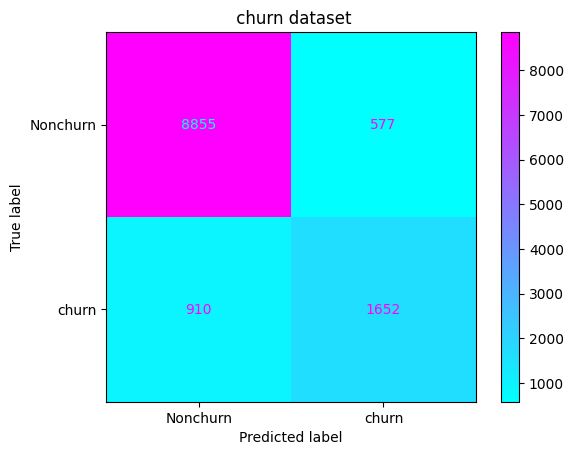

    total_predicted : 11994
    invalid : 1487
    accuracy : 0.876
    Sensitivity : 0.9388
    Specificity : 0.6448
    f1_score : 0.9225


In [49]:
conf_matrix(y_pred, y_test,"churn")

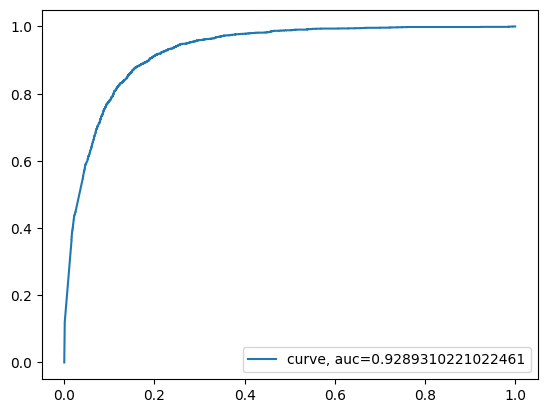

In [38]:
y_pred_proba = loaded_model.predict_proba(X_test)[::,1]
fp, tp, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fp,tp,label="curve, auc="+str(auc))
plt.legend(loc=4)
plt.show()